<a href="https://colab.research.google.com/github/nmcardoso/galmorpho/blob/master/sdss_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Imports

import random
import tensorflow as tf
import numpy as np
from keras import backend as K
import os

from google.colab import drive

import shutil

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt

import multiprocessing as mp

from keras.applications import VGG16

!pip3 install git+https://github.com/nmcardoso/fitsbook-python
import fitsbook as fb

In [0]:
# Reprodutibilidade
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

os.environ['PYTHONHASHSEED'] = '12'
np.random.seed(123)
random.seed(1234)
tf.set_random_seed(12345)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, 
#                               inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

print('Sementes Plantadas!')

Sementes Plantadas!


In [0]:
# Montando Google Drive

drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
if (os.path.exists('/content/train_data')):
  shutil.rmtree('/content/train_data')
!tar -xf '/gdrive/My Drive/ml_datasets/sdss_full_80px.tar.gz' -C '/content/'
!mv '/content/downloads' '/content/train_data'

In [0]:
if (os.path.exists('/content/test_data')):
  shutil.rmtree('/content/test_data')
!mkdir '/content/test_data'

dirs = os.listdir('/content/train_data')
for di in dirs:
  files = os.listdir(f'/content/train_data/{di}')
  samples = len(files)
  test_samples = int(samples * .025)
  os.mkdir(f'/content/test_data/{di}')
  for f in files[:test_samples]:
    shutil.move(f'/content/train_data/{di}/{f}', f'/content/test_data/{di}')

In [0]:
if (os.path.exists('/content/val_data')):
  shutil.rmtree('/content/val_data')
!mkdir '/content/val_data'

dirs = os.listdir('/content/train_data')
for di in dirs:
  files = os.listdir(f'/content/train_data/{di}')
  samples = len(files)
  val_samples = int(samples * .15)
  os.mkdir(f'/content/val_data/{di}')
  for f in files[:val_samples]:
    shutil.move(f'/content/train_data/{di}/{f}', f'/content/val_data/{di}')

In [0]:
def transform_image(source, output):
  basename = os.path.basename(source)

  datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
  
  img = load_img(source)
  img_tensor = img_to_array(img)
  img_tensor = img_tensor.reshape((1,) + img_tensor.shape)

  i = 0
  for batch in datagen.flow(img_tensor, 
                            seed=123, 
                            batch_size=1,
                            save_to_dir=output, 
                            save_prefix=basename, 
                            save_format='jpeg'):
    i += 1
    if i >= 10:
      break

def batch_transform_images(concurrency=50):
  print(f'Starting data augmentation with {concurrency} parallel processes')

  transform_count = 0

  def pool_cb(result):
    nonlocal transform_count
    transform_count += 1

  paths = ['/content/train_data', '/content/val_data']

  pool = mp.Pool(processes=concurrency)
  for p in paths:
    for root, dirs, files in os.walk(p):
      for f in files:
        pool.apply_async(transform_image, callback=pool_cb, args=(os.path.join(root, f), root))

  pool.close()
  pool.join()

  print(f'Data augmentation finished with {transform_count} new images')

In [0]:
batch_transform_images(concurrency=50)

Starting data augmentation with 50 parallel processes
Data augmentation finished with 11565 new images


In [0]:
train_generator = None
val_generator = None
test_generator = None
model = None
history = None
image_size = (80, 80)

In [0]:
def preprocess():
  global train_generator, test_generator, val_generator
  # train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)
  train_datagen = ImageDataGenerator(rescale=1./255)
  val_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      '/content/train_data',
      target_size=image_size,
      batch_size=60,
      class_mode='categorical'
  )

  val_generator = val_datagen.flow_from_directory(
      '/content/val_data',
      target_size=image_size,
      batch_size=60,
      class_mode='categorical'
  )

  test_generator = test_datagen.flow_from_directory(
      '/content/test_data',
      target_size=image_size,
      batch_size=40,
      class_mode='categorical'
  )

def compile_model():
  global model
  model = models.Sequential()
  model.name = 'sdss_convolutional'
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size + (3,))))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(5, activation='softmax'))
  model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                loss='categorical_crossentropy',
                metrics=['acc'])

def fit(epochs=1):
  global model, history
  history = model.fit_generator(
      train_generator,
      # steps_per_epoch=200,
      epochs=epochs,
      # validation_steps=50,
      validation_data=val_generator,
      callbacks=[fb.callbacks.FitsbookCallback()]
  )

In [0]:
preprocess()
compile_model()

Found 89336 images belonging to 5 classes.
Found 15762 images belonging to 5 classes.
Found 2692 images belonging to 5 classes.


In [0]:
fit(epochs=15)

[Fitsbook]: Monitoring this training in real time https://natan.ninja/#/stats/11
Epoch 1/15
1489/1489 [==============================] - 45s 30ms/step - loss: 0.9738 - acc: 0.5682 - val_loss: 0.6857 - val_acc: 0.7330
Epoch 2/15
1489/1489 [==============================] - 44s 29ms/step - loss: 0.6204 - acc: 0.7455 - val_loss: 0.5233 - val_acc: 0.7918
Epoch 3/15
1489/1489 [==============================] - 44s 30ms/step - loss: 0.5241 - acc: 0.7905 - val_loss: 0.4739 - val_acc: 0.8171
Epoch 4/15
1489/1489 [==============================] - 43s 29ms/step - loss: 0.4853 - acc: 0.8081 - val_loss: 0.4771 - val_acc: 0.8065
Epoch 5/15
1489/1489 [==============================] - 44s 30ms/step - loss: 0.4643 - acc: 0.8162 - val_loss: 0.4637 - val_acc: 0.8165
Epoch 6/15
1489/1489 [==============================] - 44s 29ms/step - loss: 0.4484 - acc: 0.8236 - val_loss: 0.4313 - val_acc: 0.8284
Epoch 7/15
1489/1489 [==============================] - 44s 30ms/step - loss: 0.4349 - acc: 0.8288 - va

In [0]:
def compile_pretrained_model():
  global model
  conv_base = VGG16(
      weights='imagenet',
      include_top=False,
      input_shape=image_size+(3,)
  )
  conv_base.trainable = True

  for layer in conv_base.layers:
    layer.trainable = 'block5' in layer.name
    # layer.trainable = 'block5_conv1' == layer.name

  model = models.Sequential()
  model.name = 'sdss_pretrained'
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(2048, activation='relu'))
  model.add(layers.Dropout(.5, seed=1225))
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dropout(.5, seed=1225))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(.5, seed=1225))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dropout(.5, seed=1225))
  model.add(layers.Dense(5, activation='softmax'))
  
  model.compile(
      optimizer=optimizers.RMSprop(lr=1e-5),
      loss='categorical_crossentropy',
      metrics=['acc']
  )

def preprocess_pretained_data():
  global train_generator, test_generator, val_generator
  # train_datagen = ImageDataGenerator(rescale=1./255, validation_split=.25)
  train_datagen = ImageDataGenerator(rescale=1./255)
  val_datagen = ImageDataGenerator(rescale=1./255)
  test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(
      '/content/train_data',
      target_size=image_size,
      batch_size=60,
      class_mode='categorical'
  )

  val_generator = val_datagen.flow_from_directory(
      '/content/val_data',
      target_size=image_size,
      batch_size=60,
      class_mode='categorical'
  )

  test_generator = test_datagen.flow_from_directory(
      '/content/test_data',
      target_size=image_size,
      batch_size=40,
      class_mode='categorical'
  )

def fit_pretrained_model(epochs=1):
  global model, history
  history = model.fit_generator(
      train_generator,
      epochs=epochs,
      validation_data=val_generator,
      callbacks=[fb.callbacks.FitsbookCallback()]
  )

In [0]:
preprocess_pretained_data()
compile_pretrained_model()
model.summary()

Found 89336 images belonging to 5 classes.
Found 15762 images belonging to 5 classes.
Found 2692 images belonging to 5 classes.
58892288/58889256 [==============================] - 2s 0us/step



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sdss_pretrained"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)           

In [0]:
fit_pretrained_model(epochs=15)

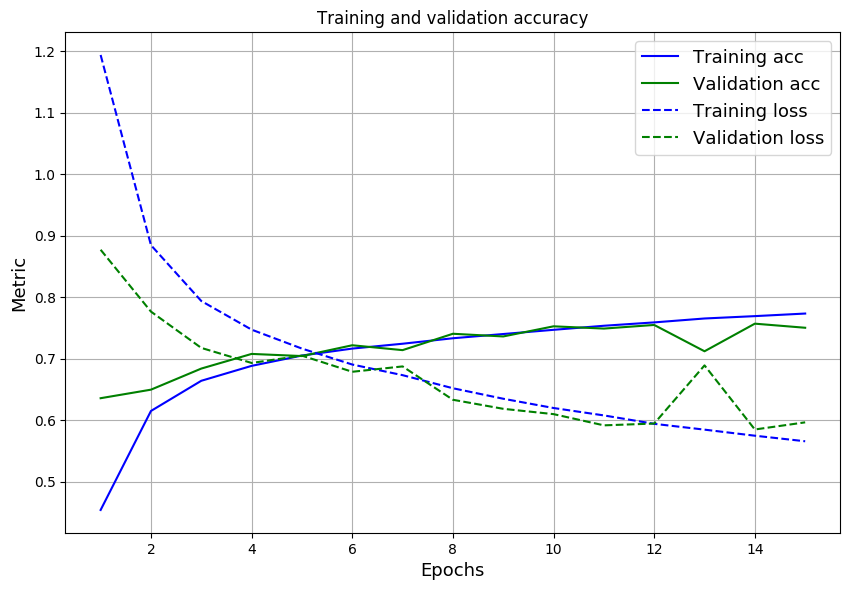

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.rcParams.update({'figure.titlesize': 16, 'axes.labelsize': 13, 'legend.fontsize': 13})
plt.figure(figsize=(10, 6.5))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.plot(epochs, loss, 'b--', label='Training loss')
plt.plot(epochs, val_loss, 'g--', label='Validation loss')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid()
plt.savefig('/content/pretrained_train.pdf', bbox_inches='tight', pad_inches=0.05)

In [0]:
model.evaluate(test_generator)

In [0]:
model.metrics_names